# ArchGAN: Facade‑to‑Photo Translator

In this notebook, we use Conditional GAN architecture for translating segmented images to real images in street view of Cityscapes dataset.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from transformers import get_cosine_schedule_with_warmup

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

## GAN

*Generative Adversarial Networks* (GANs) had shown a huge success in image generation. A **generator** that tries to generate images similar to real images, and a **discriminator** that tries to distinguish real and generated images, form a GAN. In the vanilla GAN, the input to the generator $G$, is a random noise vector $z$. The discriminator $D$ should assign $1$ to real image $y$ and $0$ to $G(z)$, while the generator should fool $D$. The objective can be described as
$$
\mathcal{L}_{\text{GAN}} (G, D) = \mathbb{E}_{y}[\log D(y)] + \mathbb{E}_{z}[\log (1-D(G(z)))]
$$
, where $D$ wants to _maximize_ and $G$ wants to _minimize_ it.

In [2]:
H = {
    'debug': False,
    'lr': 2e-4,
    'beta1': 0.5,
    'lambda': 10,
    'num_epochs': 200,
    'batch_size': 1,
    'dropout': 0.5,
    'ndf': 64,
    'ngf': 64,
}

if H['debug']:
    H['num_epochs'] = 3
    H['ndf'] = 4
    H['ngf'] = 4
    H['dropout'] = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_workers = 4

root = '/kaggle/input/cityscapes-pix2pix-dataset'
metadata_path = f'{root}/metadata.csv'

df = pd.read_csv(metadata_path)
if H['debug']:
    df = df.iloc[:20]

device, num_workers

(device(type='cuda'), 4)

## Conditional GAN

Conditional GAN adds an input condition $x$ to the GAN problem. $x$ could be a label, text, or image. In this notebook, $x$ is image. So the objective becomes
$$
\mathcal{L}_{\text{GAN}} (G, D) = \mathbb{E}_{x,y}[\log D(x,y)] + \mathbb{E}_{x,z}[\log (1-D(x, G(x,z)))]
$$
. We should add another term to our objective that measures the distance between $y$ and $G(x, z)$. It turns out that the L-2 norm will make the generated image blurred, so we will use L-1 norm for high quality outputs.

In [3]:
train_df = df[df['split'] == 'train'].reset_index(drop=True)
val_df = df[df['split'] == 'val'].reset_index(drop=True)
train_df.head()

image_id  split      image_path
0         1  train     train/1.jpg
1        10  train    train/10.jpg
2       100  train   train/100.jpg
3      1000  train  train/1000.jpg
4      1001  train  train/1001.jpg

## Pix2Pix

Pix2Pix is a framework that uses cGAN for paired image-to-image translation. [Here](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/) is the official PyTorch code for this model. We want to train Pix2Pix on a dataset used in the [original paper](https://arxiv.org/pdf/1611.07004) inspired by this code.

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

class CityDataset(Dataset):
    def __init__(self, root, df, transform):
        self.paths = df['image_path'].map(lambda x: f'{root}/{x}')
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = Image.open(self.paths[idx])
        image = np.array(image)
        real = self.transform(image[:, :256])
        segm = self.transform(image[:, 256:])
        return real, segm

def denormalize(tensor):
    image = (tensor * 0.5 + 0.5) * 255
    image = image.numpy().transpose(1, 2, 0)
    return image.astype(np.uint8)

train_set = CityDataset(root, train_df, transform)
val_set = CityDataset(root, val_df, transform)

print(f'There are {len(train_set)} train and {(len(val_set))} validation examples.')

There are 2975 train and 500 validation examples.


## Dataset

In Cityscapes dataset, there are $2975$ training pairs of street-view images $y$, and their proportional segmentation $x$. Our goal is to find the street-view image given the segmented image.

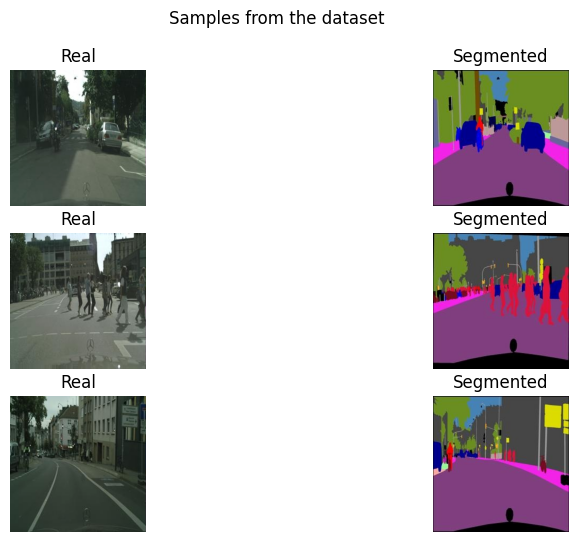

In [5]:
fig, axs = plt.subplots(3, 2, figsize=(10, 6))

for ax in axs:
    idx = np.random.randint(0, len(train_set))
    real, segm = train_set[idx]
    real = denormalize(real)
    segm = denormalize(segm)
    ax[0].imshow(real)
    ax[0].set_title('Real')
    ax[0].axis('off')
    ax[1].imshow(segm)
    ax[1].set_title('Segmented')
    ax[1].axis('off')

plt.suptitle('Samples from the dataset')
plt.show()

As described in the main paper, we use batch size $1$ which turns out to have better performance for this setting.

In [6]:
train_loader = DataLoader(train_set, batch_size=H['batch_size'], shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_set, batch_size=H['batch_size'], shuffle=False, num_workers=num_workers)

len(train_loader), len(val_loader)

(2975, 500)

## Discriminator

The discriminator consist of a sequence of Convolution-BatchNorm-ReLU blocks. The generated-real recognition is done by classifying for $N\times N$ patches, then the final output of discriminator is the average of these results. This discriminator architecture is also called *PatchGAN*.

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, norm=True):
        super(ConvBlock, self).__init__()
        conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=not norm)
        batch_norm = nn.BatchNorm2d(out_channels)
        leaky_relu = nn.LeakyReLU(0.2, True)
        if norm:
            block = [conv, batch_norm, leaky_relu]
        else:
            block = [conv, leaky_relu]
        self.block = nn.Sequential(*block)

    def forward(self, x):
        return self.block(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc=6, ndf=64):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
        """
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(input_nc, ndf, 2, norm=False),
            ConvBlock(ndf  , ndf*2, 2),
            ConvBlock(ndf*2, ndf*4, 2),
            ConvBlock(ndf*4, ndf*8, 1),
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, real, segm):
        input = torch.cat([real, segm], dim=1)
        return self.model(input)

discriminator = Discriminator(ndf=H['ndf']).to(device)

## Generator

In this framework, the generator has *U-Net* architecture. Note that all convolution blocks have kernel size $4$ and ther is no pooling layer. Using random noise for $z$ is not effective in this case, so we use dropout with high probability $0.5$ to add diversity to our generator. So at inference time, we do **not turn off dropout**.

In [8]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, outermost=False, innermost=False):
        super(DownSample, self).__init__()
        leaky_relu = nn.LeakyReLU(0.2, True)
        conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=outermost)
        batch_norm = nn.BatchNorm2d(out_channels)
        if outermost:
            down = [conv]
        elif innermost:
            down = [leaky_relu, conv]
        else:
            down = [leaky_relu, conv, batch_norm]
        self.block = nn.Sequential(*down)

    def forward(self, x):
        return self.block(x)

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, outermost=False, innermost=False, dropout=0):
        super(UpSample, self).__init__()
        in_mult = 1 if innermost else 2
        upconv = nn.ConvTranspose2d(in_channels * in_mult, out_channels, kernel_size=4, stride=2, padding=1)
        relu = nn.ReLU(True)
        batch_norm = nn.BatchNorm2d(out_channels)
        if outermost:
            up = [relu, upconv, nn.Tanh()]
        else:
            up = [relu, upconv, batch_norm]
        if dropout > 0:
            up.append(nn.Dropout(dropout))
        self.block = nn.Sequential(*up)

    def forward(self, x):
        return self.block(x)

class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, dropout=0):
        """Construct a Unet submodule with skip connections.

        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            dropout (float)  -- for dropout layers
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if input_nc is None:
            input_nc = outer_nc
        down = DownSample(input_nc, inner_nc, outermost, innermost)
        up = UpSample(inner_nc, outer_nc, outermost, innermost, dropout)
        if innermost:
            model = [down, up]
        else:
            model = [down, submodule, up]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

class Generator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, num_downs=8, ngf=64, dropout=0):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer

        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(Generator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, submodule=unet_block, dropout=dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, submodule=unet_block)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, submodule=unet_block)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, submodule=unet_block)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True)  # add the outermost layer

    def forward(self, input):
        return self.model(input)

generator = Generator(ngf=H['ngf'], dropout=H['dropout']).to(device)

The following cell is good to get familiar with dimensions in our problem.

In [9]:
for real, segm in train_loader:
    real, segm = real.to(device), segm.to(device)
    print(f'real.shape={real.shape}, segm.shape={segm.shape}')
    d_out = discriminator(real, segm)
    print(f'd_out.shape={d_out.shape}')
    g_out = generator(segm)
    print(f'g_out.shape={g_out.shape}')
    break

def count_params(model):
    return sum(p.numel() for p in model.parameters()) / 1e6

print(f'Number of parameters: Generator={count_params(generator):.2f}M, Discriminator={count_params(discriminator):.2f}M')

real.shape=torch.Size([1, 3, 256, 256]), segm.shape=torch.Size([1, 3, 256, 256])
d_out.shape=torch.Size([1, 1, 30, 30])
g_out.shape=torch.Size([1, 3, 256, 256])
Number of parameters: Generator=54.42M, Discriminator=2.77M


## Loss function

The discriminator loss is devided by $2$ to slow down the rate of learning for $D$.

$$
\mathcal{L}_D = -0.5 \big(\mathbb{E}_{x,y}[\log D(x,y)] + \mathbb{E}_{x,z}[\log (1-D(x, G(x,z)))]\big)
$$

The effect of L-1 loss for generator is controlled by hyper-parameter $\lambda$. Also it is usual to optimize $-\log(D)$ instead of $\log(1-D)$, because of gradient reasons. So the following is the final generator loss function.

$$
\mathcal{L}_G = -\mathbb{E}_{x,z}[\log D(x, G(x,z))] + \lambda \mathbb{E}_{x,z,y}\big[|| y-G(x, z) ||_1\big]
$$

In [10]:
def get_target(pred, is_true: bool):
    if is_true:
        return torch.ones_like(pred)
    else:
        return torch.zeros_like(pred)

def get_d_loss(d_model, g_model, real, segm):
    d_out_true = d_model(real, segm)
    loss_true = F.binary_cross_entropy_with_logits(d_out_true, get_target(d_out_true, True))
    with torch.no_grad():
        g_out = g_model(segm)
    d_out_false = d_model(g_out, segm)
    loss_false = F.binary_cross_entropy_with_logits(d_out_false, get_target(d_out_false, False))
    return 0.5 * (loss_true + loss_false)

def get_g_loss(d_model, g_model, real, segm, _lambda=H['lambda']):
    g_out = g_model(segm)
    d_out_false = d_model(g_out, segm)
    disc_loss = F.binary_cross_entropy_with_logits(d_out_false, get_target(d_out_false, True))
    l1_loss = F.l1_loss(g_out, real)
    return disc_loss + _lambda * l1_loss

## Optimizer

Adam solver is used as an optimizer. For training more efficiently, cosine annealing as scheduler is used.

In [11]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=H['lr'], betas=(H['beta1'], 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=H['lr'], betas=(H['beta1'], 0.999))

total_steps = len(train_loader) * H['num_epochs']
warmup_steps = total_steps // 10
d_scheduler = get_cosine_schedule_with_warmup(d_optimizer, total_steps, warmup_steps)
g_scheduler = get_cosine_schedule_with_warmup(g_optimizer, total_steps, warmup_steps)

## Hyper-parameters

Most of the hyper-parameters are identical to those in the main paper. Here is the full list:

- **learning rate:** For both discriminator and generator is $0.0002$
- **beta1:** In Adam optimizer $0.5$
- **lambda:** Importance of L-1 loss $10$
- **number of epochs:** $200$ (last version $50$), in the main paper $200$
- **batch_size:** $1$
- **dropout:** For some blocks in the decoder of U-Net in generator $0.5$
- **ndf** and **ngf:** Number of filters in discriminator and generator $64$

## Train

The training time for $200$ epochs is less than $12$ hours on Kaggle GPU P100. Note that the generator is always in train mode.

In [12]:
def train(d_model, g_model, train_loader, d_optimizer, g_optimizer, d_scheduler, g_scheduler, device):
    d_loss_epoch = 0
    g_loss_epoch = 0

    batch_freq = max(1, len(train_loader) // 10)
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc='Training')
    for i, (real, segm) in pbar:
        real, segm = real.to(device), segm.to(device)

        d_model.train()
        g_model.train()

        d_optimizer.zero_grad()
        d_loss = get_d_loss(d_model, g_model, real, segm)
        d_loss.backward()
        d_optimizer.step()

        d_model.eval()
        g_model.train()

        g_optimizer.zero_grad()
        g_loss = get_g_loss(d_model, g_model, real, segm)
        g_loss.backward()
        g_optimizer.step()

        d_scheduler.step()
        g_scheduler.step()
        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()

        if i % batch_freq == 0:
            pbar.set_postfix({'d_loss': f'{d_loss:.4f}', 'g_loss': f'{g_loss:.4f}', 'lr': f'{g_optimizer.param_groups[0]["lr"]:.3g}'})

    d_loss_epoch /= len(train_loader)
    g_loss_epoch /= len(train_loader)
    return d_loss_epoch, g_loss_epoch

@torch.no_grad()
def evaluate(d_model, g_model, val_loader, device):
    d_loss_epoch = 0
    g_loss_epoch = 0

    d_model.eval()
    g_model.train()

    batch_freq = max(1, len(val_loader) // 10)
    pbar = tqdm(enumerate(val_loader), total=len(val_loader), desc='Validation', leave=False)
    for i, (real, segm) in pbar:
        real, segm = real.to(device), segm.to(device)

        d_loss = get_d_loss(d_model, g_model, real, segm)

        g_loss = get_g_loss(d_model, g_model, real, segm)

        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()

        if i % batch_freq == 0:
            pbar.set_postfix({'d_loss': f'{d_loss:.4f}', 'g_loss': f'{g_loss:.4f}'})

    d_loss_epoch /= len(val_loader)
    g_loss_epoch /= len(val_loader)
    return d_loss_epoch, g_loss_epoch

@torch.no_grad()
def visualize(g_model, val_loader, device, n_v=2, n_h=2):
    g_model.train()
    fig, axs = plt.subplots(n_v, n_h*3, figsize=(20, 8))

    for idx, (real, segm) in enumerate(val_loader):
        if idx >= n_v + n_h:
            break
        segm = segm.to(device)
        g_out = g_model(segm)

        s_tensors = segm.cpu()
        g_tensors = g_out.cpu()

        i = idx // n_v
        j = idx % n_h
        for r_tensor, s_tensor, g_tensor in zip(real, s_tensors, g_tensors):
            axs[i, j*3].imshow(denormalize(s_tensor))
            axs[i, j*3+1].imshow(denormalize(r_tensor))
            axs[i, j*3+2].imshow(denormalize(g_tensor))
            axs[i, j*3].set_title('Segmented')
            axs[i, j*3+1].set_title('Real')
            axs[i, j*3+2].set_title('Generated')
            axs[i, j*3].axis('off')
            axs[i, j*3+1].axis('off')
            axs[i, j*3+2].axis('off')

    plt.suptitle('Example results of Pix2Pix on Cityscapes')
    plt.show()

## Save

Some results from validation set has been showen every $10$ epochs.

Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.11it/s, d_loss=0.2959, g_loss=5.0408, lr=9.99e-07]

Epoch 1/200, Train Loss: D=0.5684, G=7.1680


Validation Loss: D=0.9264, G=5.6280


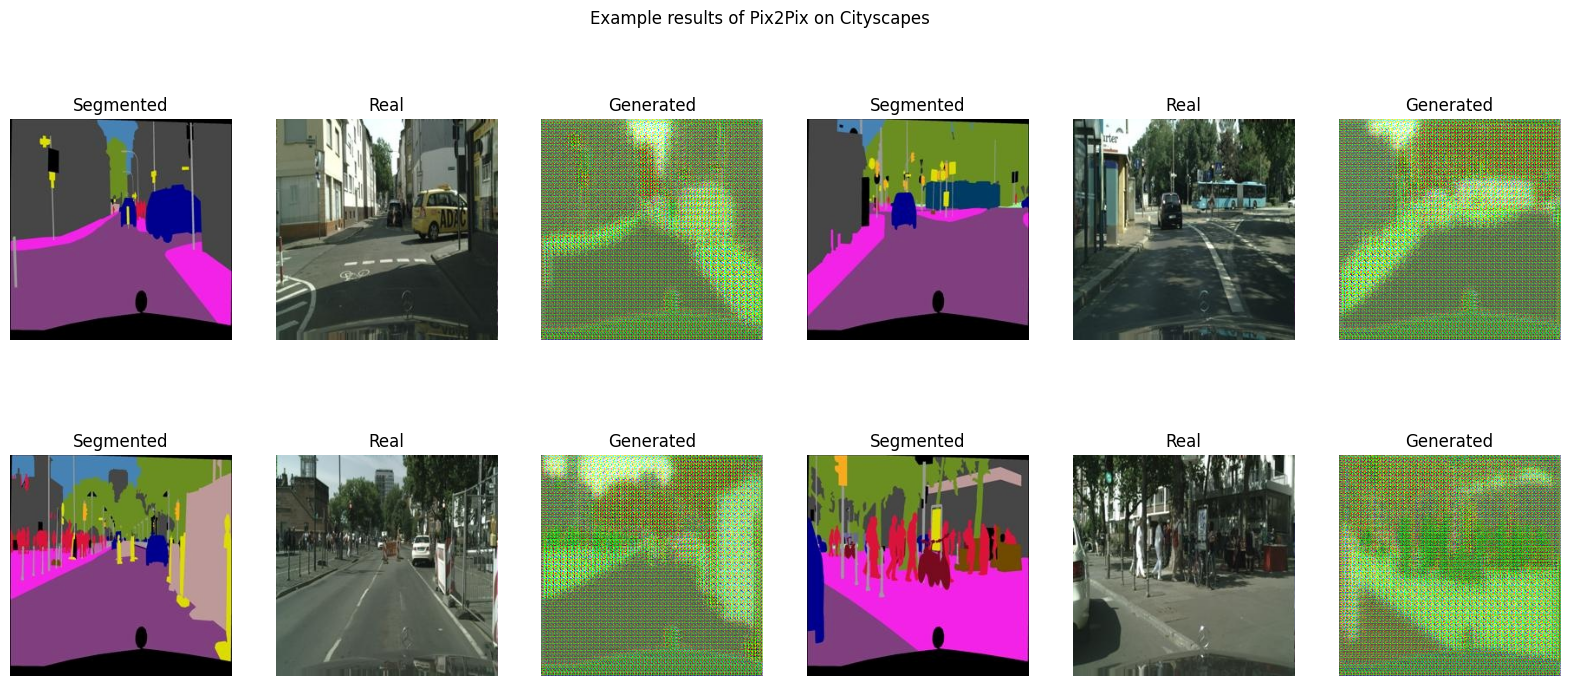

Training: 100%|██████████| 2975/2975 [02:54<00:00, 17.08it/s, d_loss=0.0339, g_loss=3.2478, lr=2e-06]

Epoch 2/200, Train Loss: D=0.1431, G=4.3290


Validation Loss: D=1.8996, G=3.6152


Training: 100%|██████████| 2975/2975 [02:54<00:00, 17.08it/s, d_loss=0.0059, g_loss=2.4365, lr=3e-06]

Epoch 3/200, Train Loss: D=0.0187, G=3.2316


Validation Loss: D=2.1679, G=2.8597


Training: 100%|██████████| 2975/2975 [02:54<00:00, 17.08it/s, d_loss=0.0011, g_loss=1.8703, lr=4e-06]

Epoch 4/200, Train Loss: D=0.0027, G=2.6233


Validation Loss: D=2.4238, G=2.6454


Training: 100%|██████████| 2975/2975 [02:54<00:00, 17.08it/s, d_loss=0.0002, g_loss=3.4753, lr=5e-06]

Epoch 5/200, Train Loss: D=0.0005, G=2.4665


Validation Loss: D=2.5535, G=2.5780


Training: 100%|██████████| 2975/2975 [02:54<00:00, 17.08it/s, d_loss=0.0001, g_loss=3.4348, lr=6e-06]

Epoch 6/200, Train Loss: D=0.0005, G=2.3446


Validation Loss: D=2.6018, G=2.4918


Training: 100%|██████████| 2975/2975 [02:54<00:00, 17.08it/s, d_loss=0.0000, g_loss=3.5914, lr=7e-06]

Epoch 7/200, Train Loss: D=0.0001, G=2.3233


Validation Loss: D=2.6422, G=2.5441


Training: 100%|██████████| 2975/2975 [02:54<00:00, 17.08it/s, d_loss=0.0000, g_loss=1.9509, lr=8e-06]

Epoch 8/200, Train Loss: D=0.0000, G=2.2642


Validation Loss: D=3.9049, G=2.3203


Training: 100%|██████████| 2975/2975 [02:54<00:00, 17.09it/s, d_loss=0.0000, g_loss=1.9320, lr=9e-06]

Epoch 9/200, Train Loss: D=0.0002, G=2.1194


Validation Loss: D=2.9354, G=2.2816


Training: 100%|██████████| 2975/2975 [02:54<00:00, 17.08it/s, d_loss=0.0000, g_loss=2.3256, lr=1e-05]

Epoch 10/200, Train Loss: D=0.0000, G=2.0568


Validation Loss: D=2.6957, G=2.3188


Training: 100%|██████████| 2975/2975 [02:54<00:00, 17.09it/s, d_loss=0.0000, g_loss=2.4155, lr=1.1e-05]

Epoch 11/200, Train Loss: D=0.0000, G=2.0719


Validation Loss: D=3.0995, G=2.2670


Training: 100%|██████████| 2975/2975 [02:54<00:00, 17.09it/s, d_loss=0.0000, g_loss=2.4539, lr=1.2e-05]

Epoch 12/200, Train Loss: D=0.0006, G=1.9410


Validation Loss: D=2.8789, G=2.1619


Training: 100%|██████████| 2975/2975 [02:54<00:00, 17.08it/s, d_loss=0.0000, g_loss=2.0089, lr=1.3e-05]

Epoch 13/200, Train Loss: D=0.0000, G=1.9179


Validation Loss: D=3.2395, G=2.2581


Training: 100%|██████████| 2975/2975 [02:54<00:00, 17.09it/s, d_loss=0.0000, g_loss=1.4199, lr=1.4e-05]

Epoch 14/200, Train Loss: D=0.0000, G=1.9117


Validation Loss: D=3.1101, G=2.2592


Training: 100%|██████████| 2975/2975 [02:54<00:00, 17.09it/s, d_loss=0.0000, g_loss=1.8059, lr=1.5e-05]

Epoch 15/200, Train Loss: D=0.0000, G=1.8628


Validation Loss: D=3.2961, G=2.3184


Training: 100%|██████████| 2975/2975 [02:54<00:00, 17.10it/s, d_loss=0.0000, g_loss=2.3865, lr=1.6e-05]

Epoch 16/200, Train Loss: D=0.0000, G=1.8444


Validation Loss: D=3.5588, G=2.2516


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.10it/s, d_loss=0.0000, g_loss=2.0507, lr=1.7e-05]

Epoch 17/200, Train Loss: D=0.0000, G=1.8498


Validation Loss: D=3.5952, G=2.3797


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.11it/s, d_loss=0.0000, g_loss=1.6924, lr=1.8e-05]

Epoch 18/200, Train Loss: D=0.0008, G=1.7474


Validation Loss: D=4.3431, G=2.1195


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.11it/s, d_loss=0.0000, g_loss=2.4136, lr=1.9e-05]

Epoch 19/200, Train Loss: D=0.0000, G=1.6541


Validation Loss: D=3.8715, G=2.1683


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.11it/s, d_loss=0.0000, g_loss=1.2423, lr=2e-05]

Epoch 20/200, Train Loss: D=0.0000, G=1.6323


Validation Loss: D=3.8311, G=2.1771


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.14it/s, d_loss=0.0000, g_loss=1.3974, lr=2.1e-05]

Epoch 21/200, Train Loss: D=0.0000, G=1.6386


Validation Loss: D=3.5522, G=2.2002


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.16it/s, d_loss=0.0000, g_loss=1.7594, lr=2.2e-05]

Epoch 22/200, Train Loss: D=0.0000, G=1.6617


Validation Loss: D=3.4225, G=2.2660


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.16it/s, d_loss=0.0000, g_loss=1.9367, lr=2.3e-05]

Epoch 23/200, Train Loss: D=0.0000, G=1.7250


Validation Loss: D=3.0166, G=2.3069


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.16it/s, d_loss=0.0000, g_loss=1.6584, lr=2.4e-05]

Epoch 24/200, Train Loss: D=0.0000, G=1.7771


Validation Loss: D=3.2507, G=2.3964


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.14it/s, d_loss=0.0000, g_loss=1.9305, lr=2.5e-05]

Epoch 25/200, Train Loss: D=0.0000, G=1.8064


Validation Loss: D=3.4612, G=2.4309


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.14it/s, d_loss=0.0000, g_loss=1.3743, lr=2.6e-05]

Epoch 26/200, Train Loss: D=0.0000, G=1.7833


Validation Loss: D=3.4699, G=2.3776


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.12it/s, d_loss=0.0000, g_loss=2.2897, lr=2.7e-05]

Epoch 27/200, Train Loss: D=0.0000, G=1.7519


Validation Loss: D=3.4541, G=2.3630


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.15it/s, d_loss=0.0000, g_loss=1.8935, lr=2.8e-05]

Epoch 28/200, Train Loss: D=0.0000, G=1.7682


Validation Loss: D=3.6988, G=2.4048


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.11it/s, d_loss=0.0000, g_loss=1.6694, lr=2.9e-05]

Epoch 29/200, Train Loss: D=0.0000, G=1.7798


Validation Loss: D=3.7323, G=2.4547


Training: 100%|██████████| 2975/2975 [02:54<00:00, 17.05it/s, d_loss=0.0000, g_loss=1.7532, lr=3e-05]

Epoch 30/200, Train Loss: D=0.0000, G=1.7786


Validation Loss: D=3.9226, G=2.4816


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.15it/s, d_loss=0.0000, g_loss=2.0640, lr=3.1e-05]

Epoch 31/200, Train Loss: D=0.0000, G=1.7725


Validation Loss: D=3.8551, G=2.4776


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.16it/s, d_loss=0.0000, g_loss=1.3967, lr=3.2e-05]

Epoch 32/200, Train Loss: D=0.0000, G=1.7686


Validation Loss: D=3.7594, G=2.4486


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.16it/s, d_loss=0.0000, g_loss=1.7564, lr=3.3e-05]

Epoch 33/200, Train Loss: D=0.0000, G=1.7592


Validation Loss: D=3.8253, G=2.4702


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.16it/s, d_loss=0.0000, g_loss=1.7777, lr=3.4e-05]

Epoch 34/200, Train Loss: D=0.0000, G=1.7519


Validation Loss: D=3.8450, G=2.4439


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.14it/s, d_loss=0.0000, g_loss=1.6851, lr=3.5e-05]

Epoch 35/200, Train Loss: D=0.0000, G=1.7460


Validation Loss: D=3.8384, G=2.4563


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.15it/s, d_loss=0.0000, g_loss=1.5598, lr=3.6e-05]

Epoch 36/200, Train Loss: D=0.0000, G=1.7345


Validation Loss: D=3.8924, G=2.5055


Training: 100%|██████████| 2975/2975 [02:56<00:00, 16.89it/s, d_loss=0.0000, g_loss=1.9683, lr=3.7e-05]

Epoch 37/200, Train Loss: D=0.0000, G=1.7323


Validation Loss: D=3.9797, G=2.4981


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.14it/s, d_loss=0.0000, g_loss=1.5147, lr=3.8e-05]

Epoch 38/200, Train Loss: D=0.0000, G=1.7196


Validation Loss: D=4.0964, G=2.4893


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.15it/s, d_loss=0.0000, g_loss=1.8070, lr=3.9e-05]

Epoch 39/200, Train Loss: D=0.0000, G=1.7133


Validation Loss: D=4.0468, G=2.4848


Training: 100%|██████████| 2975/2975 [02:54<00:00, 17.10it/s, d_loss=0.0000, g_loss=1.6474, lr=4e-05]

Epoch 40/200, Train Loss: D=0.0000, G=1.7012


Validation Loss: D=4.0504, G=2.5009


Training: 100%|██████████| 2975/2975 [02:54<00:00, 17.09it/s, d_loss=0.0000, g_loss=1.7767, lr=4.1e-05]

Epoch 41/200, Train Loss: D=0.0000, G=1.6974


Validation Loss: D=4.0153, G=2.4999


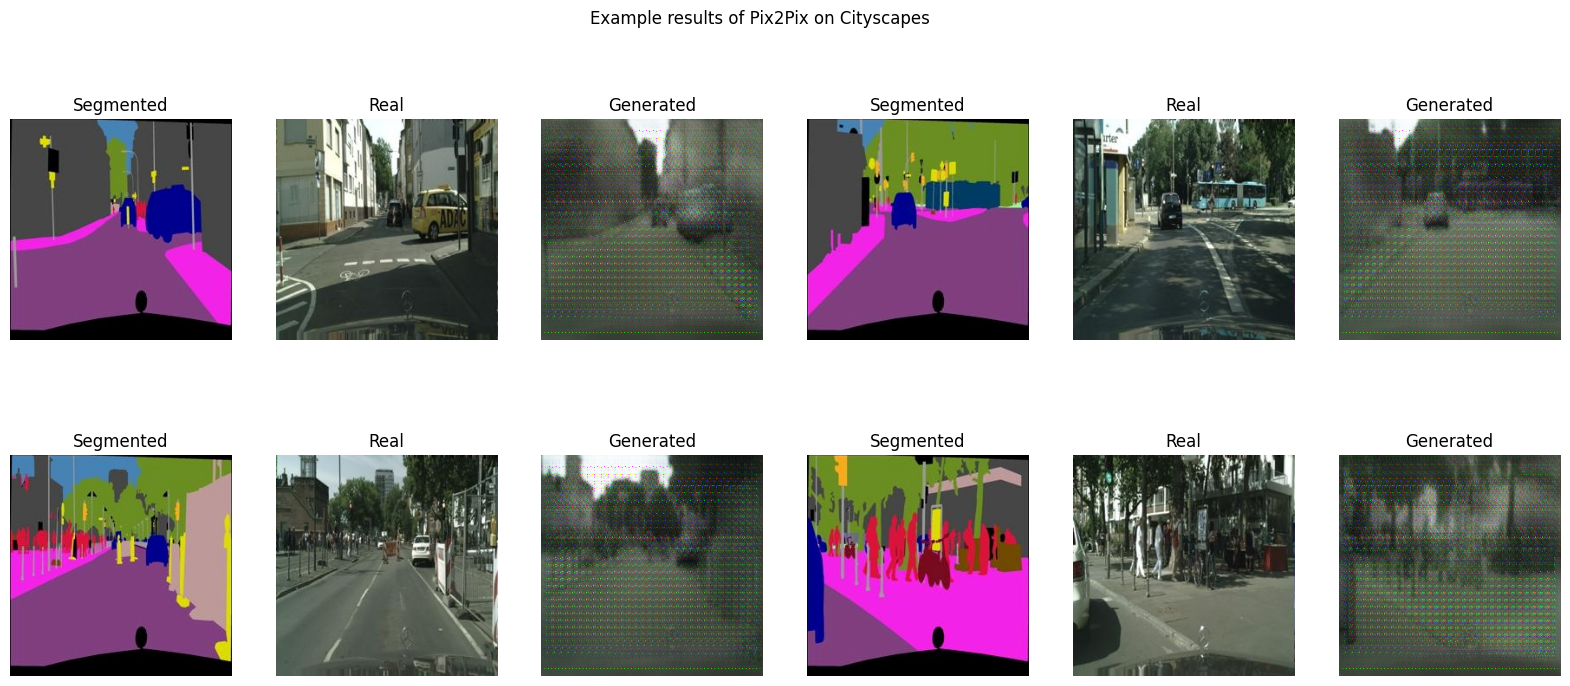

Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.10it/s, d_loss=0.0000, g_loss=1.6040, lr=4.2e-05]

Epoch 42/200, Train Loss: D=0.0000, G=1.6847


Validation Loss: D=4.1141, G=2.4912


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.10it/s, d_loss=0.0000, g_loss=1.7918, lr=4.3e-05]

Epoch 43/200, Train Loss: D=0.0000, G=1.6797


Validation Loss: D=3.9919, G=2.4559


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.11it/s, d_loss=0.0000, g_loss=2.0660, lr=4.4e-05]

Epoch 44/200, Train Loss: D=0.0000, G=1.6787


Validation Loss: D=4.2228, G=2.5035


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.11it/s, d_loss=0.0000, g_loss=1.6803, lr=4.5e-05]

Epoch 45/200, Train Loss: D=0.0000, G=1.6802


Validation Loss: D=4.0803, G=2.4531


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.10it/s, d_loss=0.0000, g_loss=1.3943, lr=4.6e-05]

Epoch 46/200, Train Loss: D=0.0000, G=1.6806


Validation Loss: D=4.2624, G=2.5055


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.10it/s, d_loss=0.0000, g_loss=1.8820, lr=4.7e-05]

Epoch 47/200, Train Loss: D=0.0000, G=1.6826


Validation Loss: D=4.1253, G=2.5542


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.10it/s, d_loss=0.0000, g_loss=1.8741, lr=4.8e-05]

Epoch 48/200, Train Loss: D=0.0000, G=1.6895


Validation Loss: D=4.0978, G=2.5509


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.11it/s, d_loss=0.0000, g_loss=2.0380, lr=4.9e-05]

Epoch 49/200, Train Loss: D=0.0000, G=1.6936


Validation Loss: D=4.3583, G=2.5676


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=1.9017, lr=5e-05]

Epoch 50/200, Train Loss: D=0.0000, G=1.6805


Validation Loss: D=4.3455, G=2.5485


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.29it/s, d_loss=0.0000, g_loss=1.7529, lr=5.1e-05]

Epoch 51/200, Train Loss: D=0.0000, G=1.6586


Validation Loss: D=4.2690, G=2.5025


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=1.5314, lr=5.2e-05]

Epoch 52/200, Train Loss: D=0.0000, G=1.6523


Validation Loss: D=4.2866, G=2.5048


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.25it/s, d_loss=0.0000, g_loss=1.5860, lr=5.3e-05]

Epoch 53/200, Train Loss: D=0.0000, G=1.6523


Validation Loss: D=4.4941, G=2.5779


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=1.4202, lr=5.4e-05]

Epoch 54/200, Train Loss: D=0.0000, G=1.6519


Validation Loss: D=4.4260, G=2.6027


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.26it/s, d_loss=0.0000, g_loss=1.7614, lr=5.5e-05]

Epoch 55/200, Train Loss: D=0.0000, G=1.6566


Validation Loss: D=4.4929, G=2.5153


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.26it/s, d_loss=0.0000, g_loss=1.6033, lr=5.6e-05]

Epoch 56/200, Train Loss: D=0.0000, G=1.6594


Validation Loss: D=4.3875, G=2.5640


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=1.7478, lr=5.7e-05]

Epoch 57/200, Train Loss: D=0.0000, G=1.6563


Validation Loss: D=4.4113, G=2.5325


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=1.8442, lr=5.8e-05]

Epoch 58/200, Train Loss: D=0.0000, G=1.6614


Validation Loss: D=4.3585, G=2.5366


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=1.7540, lr=5.9e-05]

Epoch 59/200, Train Loss: D=0.0000, G=1.6630


Validation Loss: D=4.4723, G=2.5899


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=1.8539, lr=6e-05]

Epoch 60/200, Train Loss: D=0.0000, G=1.6660


Validation Loss: D=4.3805, G=2.5554


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=1.5753, lr=6.1e-05]

Epoch 61/200, Train Loss: D=0.0000, G=1.6623


Validation Loss: D=4.4606, G=2.5653


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.26it/s, d_loss=0.0000, g_loss=1.6230, lr=6.2e-05]

Epoch 62/200, Train Loss: D=0.0000, G=1.6701


Validation Loss: D=4.5208, G=2.5586


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.26it/s, d_loss=0.0000, g_loss=1.5409, lr=6.3e-05]

Epoch 63/200, Train Loss: D=0.0000, G=1.6680


Validation Loss: D=4.5644, G=2.6104


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.24it/s, d_loss=0.0000, g_loss=1.5748, lr=6.4e-05]

Epoch 64/200, Train Loss: D=0.0000, G=1.6711


Validation Loss: D=4.5010, G=2.5797


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=1.8561, lr=6.5e-05]

Epoch 65/200, Train Loss: D=0.0000, G=1.6721


Validation Loss: D=4.4406, G=2.6258


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.26it/s, d_loss=0.0000, g_loss=1.6875, lr=6.6e-05]

Epoch 66/200, Train Loss: D=0.0000, G=1.6742


Validation Loss: D=4.6157, G=2.5879


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.26it/s, d_loss=0.0000, g_loss=1.5915, lr=6.7e-05]

Epoch 67/200, Train Loss: D=0.0000, G=1.6781


Validation Loss: D=4.4749, G=2.6258


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=1.6949, lr=6.8e-05]

Epoch 68/200, Train Loss: D=0.0000, G=1.6780


Validation Loss: D=4.6956, G=2.6083


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.25it/s, d_loss=0.0000, g_loss=1.5739, lr=6.9e-05]

Epoch 69/200, Train Loss: D=0.0000, G=1.6831


Validation Loss: D=4.6181, G=2.5967


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=1.7136, lr=7e-05]

Epoch 70/200, Train Loss: D=0.0000, G=1.6823


Validation Loss: D=4.7322, G=2.5955


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.25it/s, d_loss=0.0000, g_loss=1.4250, lr=7.1e-05]

Epoch 71/200, Train Loss: D=0.0000, G=1.6809


Validation Loss: D=4.6041, G=2.6212


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=1.8639, lr=7.2e-05]

Epoch 72/200, Train Loss: D=0.0000, G=1.6820


Validation Loss: D=4.5706, G=2.6311


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.26it/s, d_loss=0.0000, g_loss=1.9279, lr=7.3e-05]

Epoch 73/200, Train Loss: D=0.0000, G=1.6832


Validation Loss: D=4.7074, G=2.6861


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.26it/s, d_loss=0.0000, g_loss=1.5974, lr=7.4e-05]

Epoch 74/200, Train Loss: D=0.0000, G=1.6866


Validation Loss: D=4.4867, G=2.6135


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.26it/s, d_loss=0.0000, g_loss=1.8140, lr=7.5e-05]

Epoch 75/200, Train Loss: D=0.0000, G=1.6856


Validation Loss: D=4.5308, G=2.6877


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.26it/s, d_loss=0.0000, g_loss=1.4867, lr=7.6e-05]

Epoch 76/200, Train Loss: D=0.0000, G=1.6860


Validation Loss: D=4.5594, G=2.6125


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.26it/s, d_loss=0.0000, g_loss=1.5212, lr=7.7e-05]

Epoch 77/200, Train Loss: D=0.0000, G=1.6868


Validation Loss: D=4.5644, G=2.6152


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.26it/s, d_loss=0.0000, g_loss=1.5837, lr=7.8e-05]

Epoch 78/200, Train Loss: D=0.0000, G=1.6833


Validation Loss: D=4.4979, G=2.6810


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.26it/s, d_loss=0.0000, g_loss=1.7030, lr=7.9e-05]

Epoch 79/200, Train Loss: D=0.0000, G=1.6840


Validation Loss: D=4.4319, G=2.6344


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.26it/s, d_loss=0.0000, g_loss=1.9632, lr=8e-05]

Epoch 80/200, Train Loss: D=0.0000, G=1.6858


Validation Loss: D=4.5699, G=2.6752


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.20it/s, d_loss=0.0000, g_loss=1.8245, lr=8.1e-05]

Epoch 81/200, Train Loss: D=0.0000, G=1.6819


Validation Loss: D=4.4798, G=2.6512


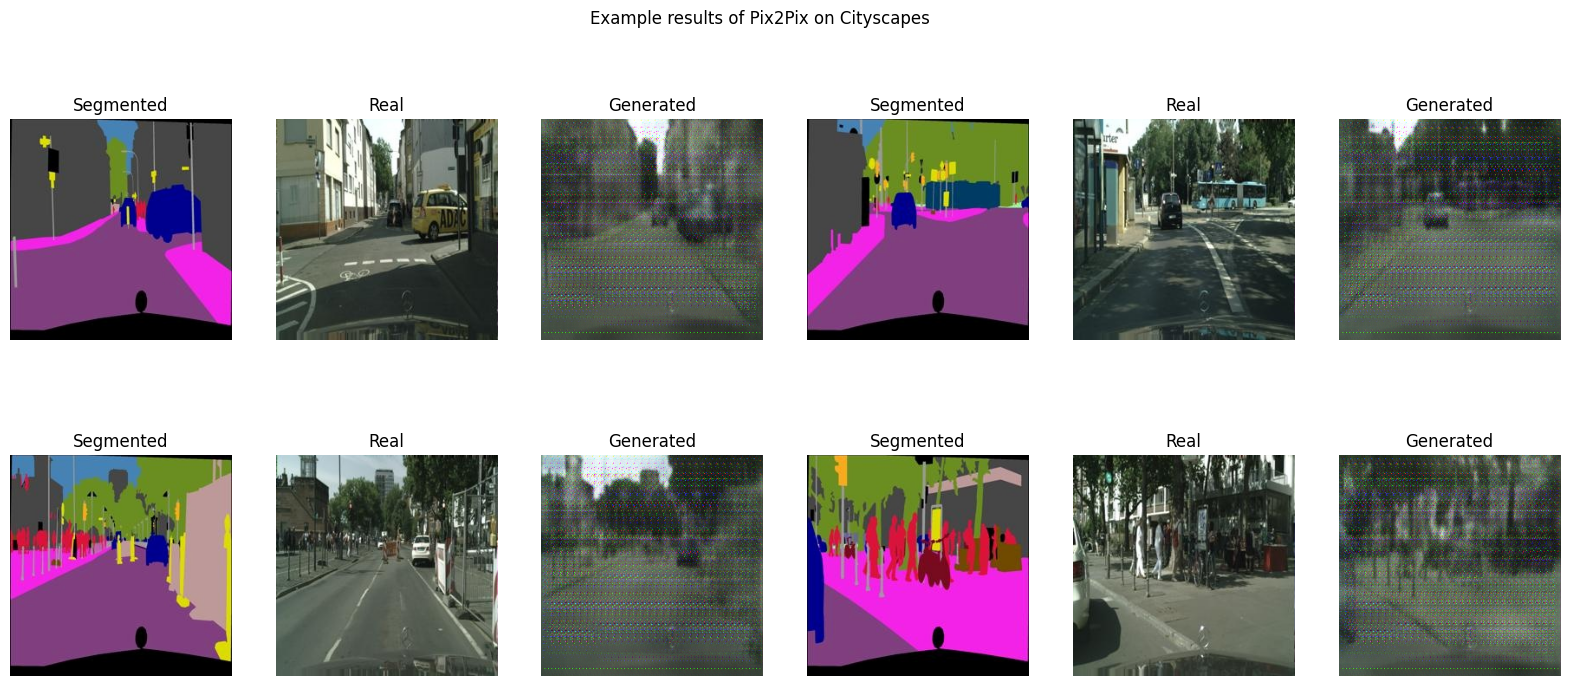

Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.20it/s, d_loss=0.0000, g_loss=2.0344, lr=8.2e-05]

Epoch 82/200, Train Loss: D=0.0000, G=1.6844


Validation Loss: D=4.6380, G=2.6869


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=1.7932, lr=8.3e-05]

Epoch 83/200, Train Loss: D=0.0000, G=1.6845


Validation Loss: D=4.5989, G=2.6952


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=1.5763, lr=8.4e-05]

Epoch 84/200, Train Loss: D=0.0000, G=1.6807


Validation Loss: D=4.7402, G=2.6691


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.5370, lr=8.5e-05]

Epoch 85/200, Train Loss: D=0.0000, G=1.6790


Validation Loss: D=4.5440, G=2.6243


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.20it/s, d_loss=0.0000, g_loss=1.5360, lr=8.6e-05]

Epoch 86/200, Train Loss: D=0.0000, G=1.6795


Validation Loss: D=4.8273, G=2.6749


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.6150, lr=8.7e-05]

Epoch 87/200, Train Loss: D=0.0000, G=1.6710


Validation Loss: D=4.6087, G=2.6688


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=1.4782, lr=8.8e-05]

Epoch 88/200, Train Loss: D=0.0000, G=1.6695


Validation Loss: D=4.7710, G=2.6791


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.20it/s, d_loss=0.0000, g_loss=1.6313, lr=8.9e-05]

Epoch 89/200, Train Loss: D=0.0000, G=1.6630


Validation Loss: D=4.6803, G=2.6621


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=1.7062, lr=9e-05]

Epoch 90/200, Train Loss: D=0.0000, G=1.6647


Validation Loss: D=4.7287, G=2.6627


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=1.8501, lr=9.1e-05]

Epoch 91/200, Train Loss: D=0.0000, G=1.6624


Validation Loss: D=4.7855, G=2.7132


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=2.0613, lr=9.2e-05]

Epoch 92/200, Train Loss: D=0.0000, G=1.6579


Validation Loss: D=4.6818, G=2.6333


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=1.8061, lr=9.3e-05]

Epoch 93/200, Train Loss: D=0.0000, G=1.6549


Validation Loss: D=4.7294, G=2.6906


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=1.5150, lr=9.4e-05]

Epoch 94/200, Train Loss: D=0.0000, G=1.6535


Validation Loss: D=4.7120, G=2.6428


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=1.7224, lr=9.5e-05]

Epoch 95/200, Train Loss: D=0.0000, G=1.6523


Validation Loss: D=4.7879, G=2.6325


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=1.4685, lr=9.6e-05]

Epoch 96/200, Train Loss: D=0.0000, G=1.6545


Validation Loss: D=4.7246, G=2.6628


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.5787, lr=9.7e-05]

Epoch 97/200, Train Loss: D=0.0000, G=1.6539


Validation Loss: D=4.8112, G=2.6758


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.7309, lr=9.8e-05]

Epoch 98/200, Train Loss: D=0.0000, G=1.6563


Validation Loss: D=4.9492, G=2.6833


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.5692, lr=9.9e-05]

Epoch 99/200, Train Loss: D=0.0000, G=1.6535


Validation Loss: D=4.8300, G=2.6805


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.6567, lr=0.0001]

Epoch 100/200, Train Loss: D=0.0000, G=1.6519


Validation Loss: D=4.8837, G=2.7133


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=1.6526, lr=0.000101]

Epoch 101/200, Train Loss: D=0.0000, G=1.6560


Validation Loss: D=4.7672, G=2.6866


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.25it/s, d_loss=0.0000, g_loss=1.6259, lr=0.000102]

Epoch 102/200, Train Loss: D=0.0000, G=1.6512


Validation Loss: D=4.7790, G=2.6205


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.7798, lr=0.000103]

Epoch 103/200, Train Loss: D=0.0000, G=1.6507


Validation Loss: D=4.7617, G=2.6686


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=2.0261, lr=0.000104]

Epoch 104/200, Train Loss: D=0.0000, G=1.6495


Validation Loss: D=4.7813, G=2.6610


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.20it/s, d_loss=0.0000, g_loss=1.5052, lr=0.000105]

Epoch 105/200, Train Loss: D=0.0000, G=1.6499


Validation Loss: D=4.8187, G=2.6781


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.5981, lr=0.000106]

Epoch 106/200, Train Loss: D=0.0000, G=1.6513


Validation Loss: D=4.8053, G=2.6837


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.5785, lr=0.000107]

Epoch 107/200, Train Loss: D=0.0000, G=1.6529


Validation Loss: D=4.7946, G=2.6941


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.7781, lr=0.000108]

Epoch 108/200, Train Loss: D=0.0000, G=1.6465


Validation Loss: D=4.8384, G=2.6786


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.5361, lr=0.000109]

Epoch 109/200, Train Loss: D=0.0000, G=1.6522


Validation Loss: D=4.8390, G=2.6992


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.6337, lr=0.00011]

Epoch 110/200, Train Loss: D=0.0000, G=1.6546


Validation Loss: D=4.8925, G=2.6596


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.5886, lr=0.000111]

Epoch 111/200, Train Loss: D=0.0000, G=1.6519


Validation Loss: D=4.8779, G=2.6957


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.6558, lr=0.000112]

Epoch 112/200, Train Loss: D=0.0000, G=1.6584


Validation Loss: D=4.8821, G=2.7250


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=2.0557, lr=0.000113]

Epoch 113/200, Train Loss: D=0.0000, G=1.6588


Validation Loss: D=4.8090, G=2.6562


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.4627, lr=0.000114]

Epoch 114/200, Train Loss: D=0.0000, G=1.6599


Validation Loss: D=4.8520, G=2.7027


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.20it/s, d_loss=0.0000, g_loss=1.8203, lr=0.000115]

Epoch 115/200, Train Loss: D=0.0000, G=1.6629


Validation Loss: D=4.8825, G=2.6840


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=1.8378, lr=0.000116]

Epoch 116/200, Train Loss: D=0.0000, G=1.6616


Validation Loss: D=4.9395, G=2.7238


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=1.5077, lr=0.000117]

Epoch 117/200, Train Loss: D=0.0000, G=1.6643


Validation Loss: D=4.9245, G=2.7064


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=1.6346, lr=0.000118]

Epoch 118/200, Train Loss: D=0.0000, G=1.6654


Validation Loss: D=5.0055, G=2.7414


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.7064, lr=0.000119]

Epoch 119/200, Train Loss: D=0.0000, G=1.6713


Validation Loss: D=4.8752, G=2.7118


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=1.6794, lr=0.00012]

Epoch 120/200, Train Loss: D=0.0000, G=1.6715


Validation Loss: D=4.9545, G=2.7284


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.7288, lr=0.000121]

Epoch 121/200, Train Loss: D=0.0000, G=1.6656


Validation Loss: D=4.9656, G=2.7201


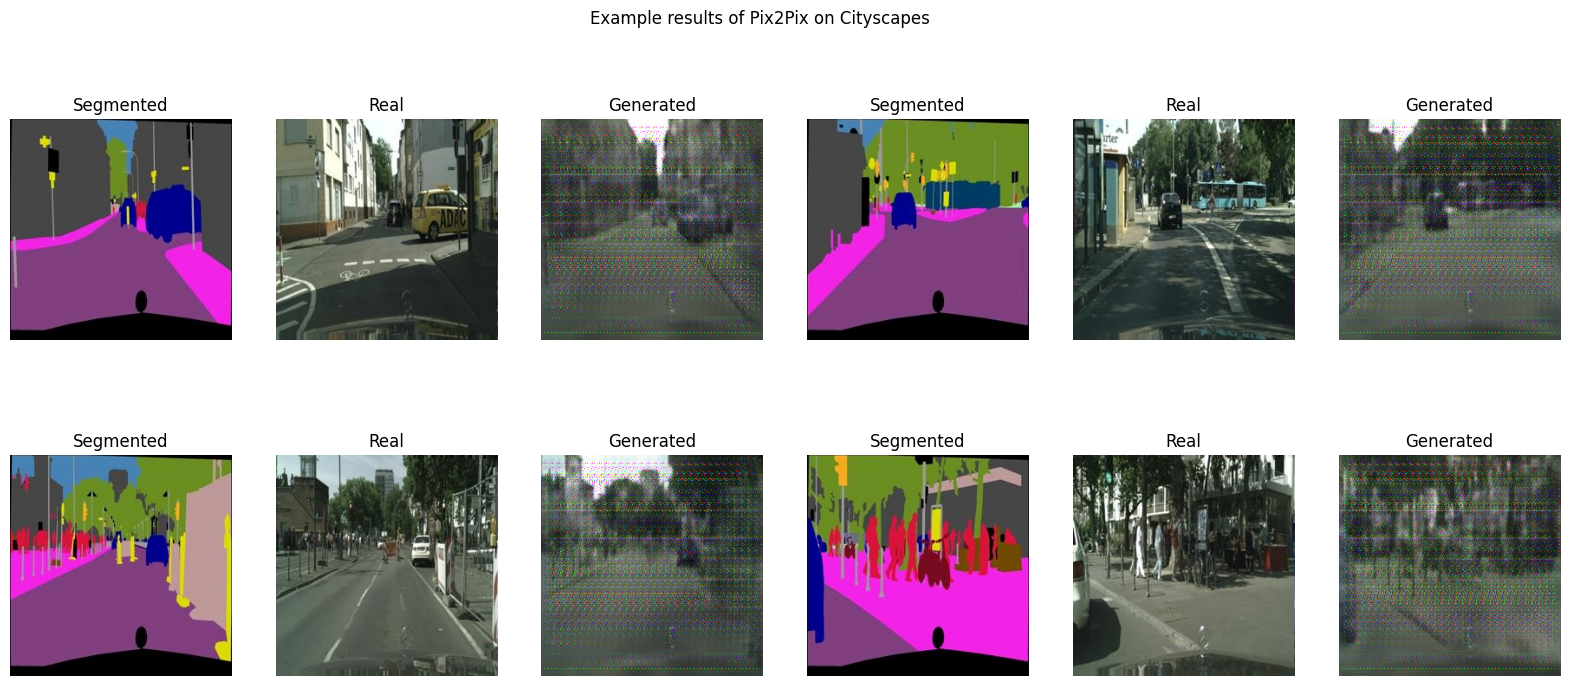

Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.7254, lr=0.000122]

Epoch 122/200, Train Loss: D=0.0000, G=1.6734


Validation Loss: D=5.0185, G=2.7311


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=1.4090, lr=0.000123]

Epoch 123/200, Train Loss: D=0.0000, G=1.6700


Validation Loss: D=4.9066, G=2.7201


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.7636, lr=0.000124]

Epoch 124/200, Train Loss: D=0.0000, G=1.6657


Validation Loss: D=4.9585, G=2.7208


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.6428, lr=0.000125]

Epoch 125/200, Train Loss: D=0.0000, G=1.6731


Validation Loss: D=4.9014, G=2.7490


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.7967, lr=0.000126]

Epoch 126/200, Train Loss: D=0.0000, G=1.6757


Validation Loss: D=4.9145, G=2.7010


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.6209, lr=0.000127]

Epoch 127/200, Train Loss: D=0.0000, G=1.6778


Validation Loss: D=4.8040, G=2.7524


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.7740, lr=0.000128]

Epoch 128/200, Train Loss: D=0.0000, G=1.6848


Validation Loss: D=4.9597, G=2.7287


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0002, g_loss=1.3335, lr=0.000129]

Epoch 129/200, Train Loss: D=0.0349, G=2.2345


Validation Loss: D=4.7882, G=2.3282


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.23it/s, d_loss=0.0019, g_loss=0.7708, lr=0.00013]

Epoch 130/200, Train Loss: D=0.0118, G=1.1657


Validation Loss: D=3.2600, G=2.2253


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0001, g_loss=0.8728, lr=0.000131]

Epoch 131/200, Train Loss: D=0.0058, G=0.9901


Validation Loss: D=29.5074, G=2.3303


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=1.1342, lr=0.000132]

Epoch 132/200, Train Loss: D=0.0001, G=1.0157


Validation Loss: D=3.2852, G=2.2505


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=0.9157, lr=0.000133]

Epoch 133/200, Train Loss: D=0.0000, G=0.9865


Validation Loss: D=4.0094, G=2.3656


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=0.8714, lr=0.000134]

Epoch 134/200, Train Loss: D=0.0000, G=1.1678


Validation Loss: D=3.7630, G=2.2723


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.0938, lr=0.000135]

Epoch 135/200, Train Loss: D=0.0000, G=1.0044


Validation Loss: D=3.4909, G=2.2459


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=0.9069, lr=0.000136]

Epoch 136/200, Train Loss: D=0.0000, G=0.9713


Validation Loss: D=3.0776, G=2.2828


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.1969, lr=0.000137]

Epoch 137/200, Train Loss: D=0.0000, G=0.9440


Validation Loss: D=3.6377, G=2.2012


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.23it/s, d_loss=0.0008, g_loss=1.1068, lr=0.000138]

Epoch 138/200, Train Loss: D=0.0040, G=0.9892


Validation Loss: D=2.6497, G=2.2454


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=1.2304, lr=0.000139]

Epoch 139/200, Train Loss: D=0.0000, G=0.8802


Validation Loss: D=2.4991, G=2.1972


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=0.9513, lr=0.00014]

Epoch 140/200, Train Loss: D=0.0000, G=0.8654


Validation Loss: D=7.1498, G=2.1674


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0001, g_loss=0.9426, lr=0.000141]

Epoch 141/200, Train Loss: D=0.0066, G=1.0769


Validation Loss: D=3.7775, G=2.3039


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=0.9591, lr=0.000142]

Epoch 142/200, Train Loss: D=0.0000, G=1.0191


Validation Loss: D=4.3839, G=2.5168


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0000, g_loss=1.0158, lr=0.000143]

Epoch 143/200, Train Loss: D=0.0000, G=1.0829


Validation Loss: D=3.5534, G=2.3723


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=1.4402, lr=0.000144]

Epoch 144/200, Train Loss: D=0.0000, G=1.0283


Validation Loss: D=3.2233, G=2.3829


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.21it/s, d_loss=0.0000, g_loss=0.7682, lr=0.000145]

Epoch 145/200, Train Loss: D=0.0000, G=1.0063


Validation Loss: D=3.4225, G=2.2956


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.22it/s, d_loss=0.0001, g_loss=0.9851, lr=0.000146]

Epoch 146/200, Train Loss: D=0.0029, G=1.0270


Validation Loss: D=3.9575, G=2.1996


Training: 100%|██████████| 2975/2975 [02:53<00:00, 17.18it/s, d_loss=0.0009, g_loss=0.5544, lr=0.000147]

Epoch 147/200, Train Loss: D=0.0099, G=0.8825


Validation Loss: D=4.0147, G=2.1893


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.23it/s, d_loss=0.0000, g_loss=0.4867, lr=0.000148]

Epoch 148/200, Train Loss: D=0.0001, G=0.7943


Validation Loss: D=4.0745, G=2.1535


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.26it/s, d_loss=0.0000, g_loss=0.5974, lr=0.000149]

Epoch 149/200, Train Loss: D=0.0000, G=0.7938


Validation Loss: D=3.4841, G=2.1625


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=0.7814, lr=0.00015]

Epoch 150/200, Train Loss: D=0.0000, G=0.7927


Validation Loss: D=3.6668, G=2.1722


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.26it/s, d_loss=0.0000, g_loss=0.9009, lr=0.000151]

Epoch 151/200, Train Loss: D=0.0026, G=0.9936


Validation Loss: D=2.8545, G=2.3046


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=1.1184, lr=0.000152]

Epoch 152/200, Train Loss: D=0.0000, G=0.9037


Validation Loss: D=2.9988, G=2.2726


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=0.8794, lr=0.000153]

Epoch 153/200, Train Loss: D=0.0000, G=0.8695


Validation Loss: D=2.6627, G=2.1643


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.26it/s, d_loss=0.0003, g_loss=0.9465, lr=0.000154]

Epoch 154/200, Train Loss: D=0.0177, G=0.9046


Validation Loss: D=2.6654, G=2.2190


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=1.4343, lr=0.000155]

Epoch 155/200, Train Loss: D=0.0002, G=1.0740


Validation Loss: D=3.0101, G=2.3851


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=1.1165, lr=0.000156]

Epoch 156/200, Train Loss: D=0.0000, G=1.0601


Validation Loss: D=3.0407, G=2.4041


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=1.2082, lr=0.000157]

Epoch 157/200, Train Loss: D=0.0000, G=1.0418


Validation Loss: D=3.5456, G=2.3249


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=0.8094, lr=0.000158]

Epoch 158/200, Train Loss: D=0.0000, G=1.1376


Validation Loss: D=4.7231, G=2.3344


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.26it/s, d_loss=0.0000, g_loss=1.0493, lr=0.000159]

Epoch 159/200, Train Loss: D=0.0000, G=1.0083


Validation Loss: D=3.0700, G=2.4149


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.26it/s, d_loss=0.0000, g_loss=0.6820, lr=0.00016]

Epoch 160/200, Train Loss: D=0.0000, G=1.0139


Validation Loss: D=4.6800, G=2.3102


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=0.8092, lr=0.000161]

Epoch 161/200, Train Loss: D=0.0000, G=0.9823


Validation Loss: D=3.8993, G=2.2893


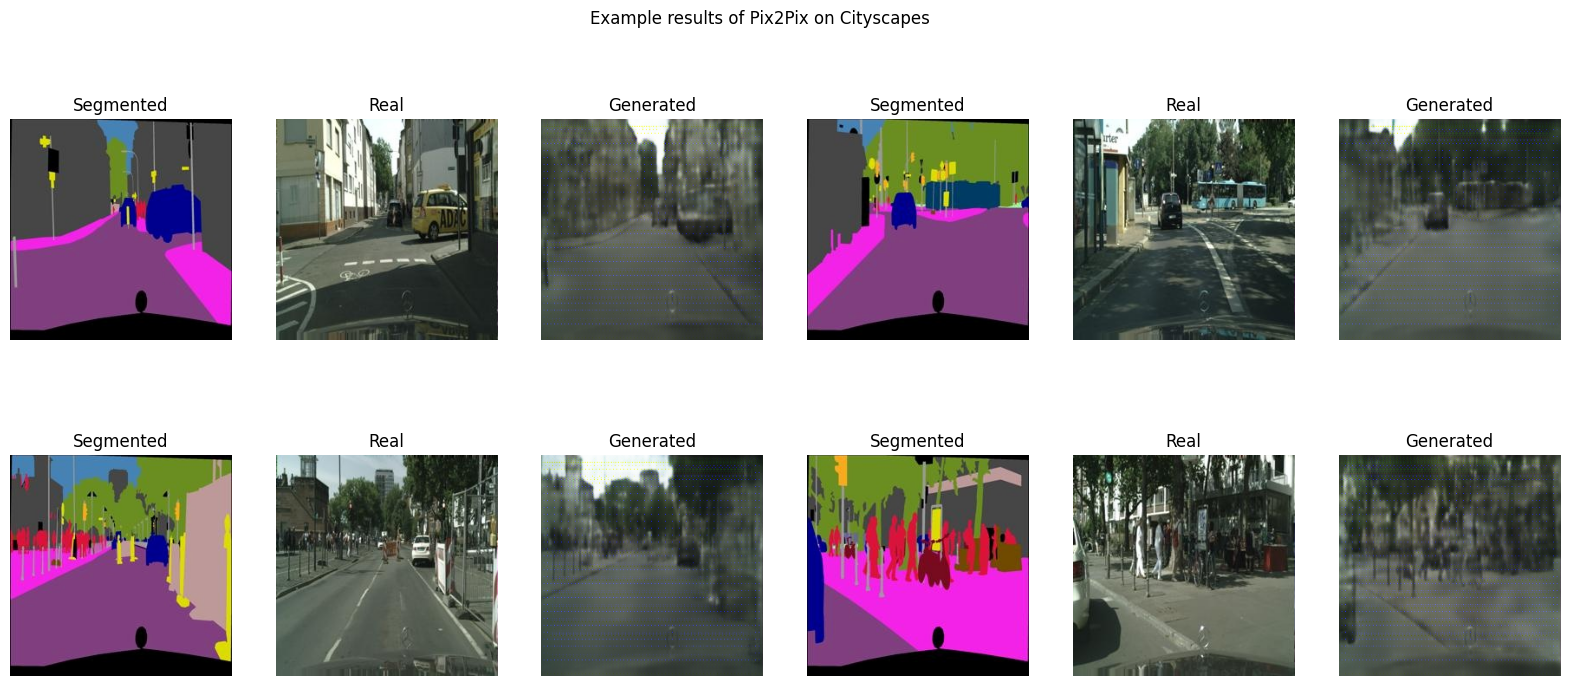

Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=0.9358, lr=0.000162]

Epoch 162/200, Train Loss: D=0.0000, G=0.9586


Validation Loss: D=3.8439, G=2.2954


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=0.7526, lr=0.000163]

Epoch 163/200, Train Loss: D=0.0000, G=0.9505


Validation Loss: D=3.7976, G=2.3108


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=1.1075, lr=0.000164]

Epoch 164/200, Train Loss: D=0.0000, G=0.9461


Validation Loss: D=4.2814, G=2.2844


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=0.9786, lr=0.000165]

Epoch 165/200, Train Loss: D=0.0000, G=0.9417


Validation Loss: D=3.9496, G=2.3167


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.29it/s, d_loss=0.0000, g_loss=1.2780, lr=0.000166]

Epoch 166/200, Train Loss: D=0.0000, G=0.9377


Validation Loss: D=4.4350, G=2.3064


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=1.1542, lr=0.000167]

Epoch 167/200, Train Loss: D=0.0000, G=0.9319


Validation Loss: D=4.6254, G=2.2755


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.29it/s, d_loss=0.0000, g_loss=0.7860, lr=0.000168]

Epoch 168/200, Train Loss: D=0.0000, G=0.9251


Validation Loss: D=4.6573, G=2.3114


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=0.9671, lr=0.000169]

Epoch 169/200, Train Loss: D=0.0000, G=0.9185


Validation Loss: D=4.6457, G=2.3109


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=0.7251, lr=0.00017]

Epoch 170/200, Train Loss: D=0.0000, G=0.9169


Validation Loss: D=4.6732, G=2.2756


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=1.0699, lr=0.000171]

Epoch 171/200, Train Loss: D=0.0000, G=0.9109


Validation Loss: D=4.5243, G=2.2924


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.29it/s, d_loss=0.0000, g_loss=0.7950, lr=0.000172]

Epoch 172/200, Train Loss: D=0.0000, G=0.9081


Validation Loss: D=5.0189, G=2.3028


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.29it/s, d_loss=0.0000, g_loss=0.9247, lr=0.000173]

Epoch 173/200, Train Loss: D=0.0000, G=0.8987


Validation Loss: D=4.9933, G=2.2721


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=0.7822, lr=0.000174]

Epoch 174/200, Train Loss: D=0.0000, G=0.8901


Validation Loss: D=4.8281, G=2.2566


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.29it/s, d_loss=0.0000, g_loss=0.7701, lr=0.000175]

Epoch 175/200, Train Loss: D=0.0000, G=0.8831


Validation Loss: D=4.5634, G=2.2649


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.29it/s, d_loss=0.0000, g_loss=0.8558, lr=0.000176]

Epoch 176/200, Train Loss: D=0.0000, G=0.8525


Validation Loss: D=4.8389, G=2.2273


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=0.8252, lr=0.000177]

Epoch 177/200, Train Loss: D=0.0000, G=0.8343


Validation Loss: D=3.7243, G=2.2036


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=0.7675, lr=0.000178]

Epoch 178/200, Train Loss: D=0.0000, G=0.8130


Validation Loss: D=4.9093, G=2.1962


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=1.0128, lr=0.000179]

Epoch 179/200, Train Loss: D=0.0000, G=0.8248


Validation Loss: D=3.4115, G=2.2421


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=0.6535, lr=0.00018]

Epoch 180/200, Train Loss: D=0.0000, G=0.8431


Validation Loss: D=3.0555, G=2.2464


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=0.7876, lr=0.000181]

Epoch 181/200, Train Loss: D=0.0000, G=0.8224


Validation Loss: D=3.2241, G=2.2291


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=0.6357, lr=0.000182]

Epoch 182/200, Train Loss: D=0.0000, G=0.8201


Validation Loss: D=3.1358, G=2.2130


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=0.7289, lr=0.000183]

Epoch 183/200, Train Loss: D=0.0000, G=0.8118


Validation Loss: D=3.1703, G=2.2315


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=0.5732, lr=0.000184]

Epoch 184/200, Train Loss: D=0.0000, G=0.8154


Validation Loss: D=2.8418, G=2.2370


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=0.9755, lr=0.000185]

Epoch 185/200, Train Loss: D=0.0000, G=0.8071


Validation Loss: D=3.0446, G=2.2042


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=0.7511, lr=0.000186]

Epoch 186/200, Train Loss: D=0.0000, G=0.8078


Validation Loss: D=2.8498, G=2.2551


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=0.9812, lr=0.000187]

Epoch 187/200, Train Loss: D=0.0000, G=0.8053


Validation Loss: D=2.9380, G=2.2296


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=0.7386, lr=0.000188]

Epoch 188/200, Train Loss: D=0.0000, G=0.8003


Validation Loss: D=3.0207, G=2.2339


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=0.7286, lr=0.000189]

Epoch 189/200, Train Loss: D=0.0000, G=0.8054


Validation Loss: D=3.1750, G=2.1937


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=0.8424, lr=0.00019]

Epoch 190/200, Train Loss: D=0.0000, G=0.7990


Validation Loss: D=3.3765, G=2.2236


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.26it/s, d_loss=0.0000, g_loss=0.6388, lr=0.000191]

Epoch 191/200, Train Loss: D=0.0000, G=0.8023


Validation Loss: D=2.8679, G=2.2359


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=0.9343, lr=0.000192]

Epoch 192/200, Train Loss: D=0.0000, G=0.8030


Validation Loss: D=2.8349, G=2.2274


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=0.7307, lr=0.000193]

Epoch 193/200, Train Loss: D=0.0000, G=0.7923


Validation Loss: D=3.3934, G=2.1992


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.25it/s, d_loss=0.0000, g_loss=0.9344, lr=0.000194]

Epoch 194/200, Train Loss: D=0.0000, G=0.8038


Validation Loss: D=2.9976, G=2.2267


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=1.0438, lr=0.000195]

Epoch 195/200, Train Loss: D=0.0000, G=0.7935


Validation Loss: D=2.9223, G=2.2287


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.28it/s, d_loss=0.0000, g_loss=0.9122, lr=0.000196]

Epoch 196/200, Train Loss: D=0.0000, G=0.7911


Validation Loss: D=3.0082, G=2.2047


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=0.8340, lr=0.000197]

Epoch 197/200, Train Loss: D=0.0000, G=0.7892


Validation Loss: D=3.2429, G=2.2547


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=1.0083, lr=0.000198]

Epoch 198/200, Train Loss: D=0.0000, G=0.8003


Validation Loss: D=2.9972, G=2.2588


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=0.7215, lr=0.000199]

Epoch 199/200, Train Loss: D=0.0000, G=0.7946


Validation Loss: D=3.0567, G=2.2272


Training: 100%|██████████| 2975/2975 [02:52<00:00, 17.27it/s, d_loss=0.0000, g_loss=0.5471, lr=0.0002]

Epoch 200/200, Train Loss: D=0.0000, G=0.7917


Validation Loss: D=4.4103, G=2.1907


In [13]:
train_d_losses = []
train_g_losses = []
val_d_losses = []
val_g_losses = []

visual_freq = max(1, H['num_epochs'] // 5)
for epoch in range(1, H['num_epochs']+1):
    train_d_loss, train_g_loss = train(discriminator, generator, train_loader, d_optimizer, g_optimizer, d_scheduler, g_scheduler, device)
    print(f'Epoch {epoch}/{H["num_epochs"]}, Train Loss: D={train_d_loss:.4f}, G={train_g_loss:.4f}')
    val_d_loss, val_g_loss = evaluate(discriminator, generator, val_loader, device)
    print(f'Validation Loss: D={val_d_loss:.4f}, G={val_g_loss:.4f}')

    train_d_losses.append(train_d_loss)
    train_g_losses.append(train_g_loss)
    val_d_losses.append(val_d_loss)
    val_g_losses.append(val_g_loss)

    if (epoch-1) % visual_freq == 0:
        visualize(generator, val_loader, device)

torch.save(discriminator.state_dict(), 'discriminator.pth')
torch.save(generator.state_dict(), 'generator.pth')

## Epoch Losses

First, the loss of the discriminator decreases. After a while, it increases due the power the generator gained by fooling the strong discriminator.

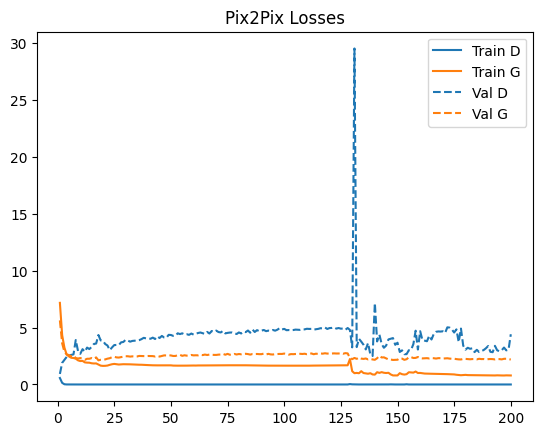

In [14]:
x = range(1, H['num_epochs']+1)
plt.plot(x, train_d_losses, label='Train D', c='tab:blue')
plt.plot(x, train_g_losses, label='Train G', c='tab:orange')
plt.plot(x, val_d_losses, label='Val D', c='tab:blue', linestyle='dashed')
plt.plot(x, val_g_losses, label='Val G', c='tab:orange', linestyle='dashed')

plt.title('Pix2Pix Losses')
plt.legend()
plt.show()

## Conclusion

Using U-Net as backbone architecture for generator and PatchGAN as discriminator, can result high-quality generated images. Batch size $1$ and high dropout increases the diversity. Pix2Pix is a very general-purpos framework for various paired image-to-image translation tasks.

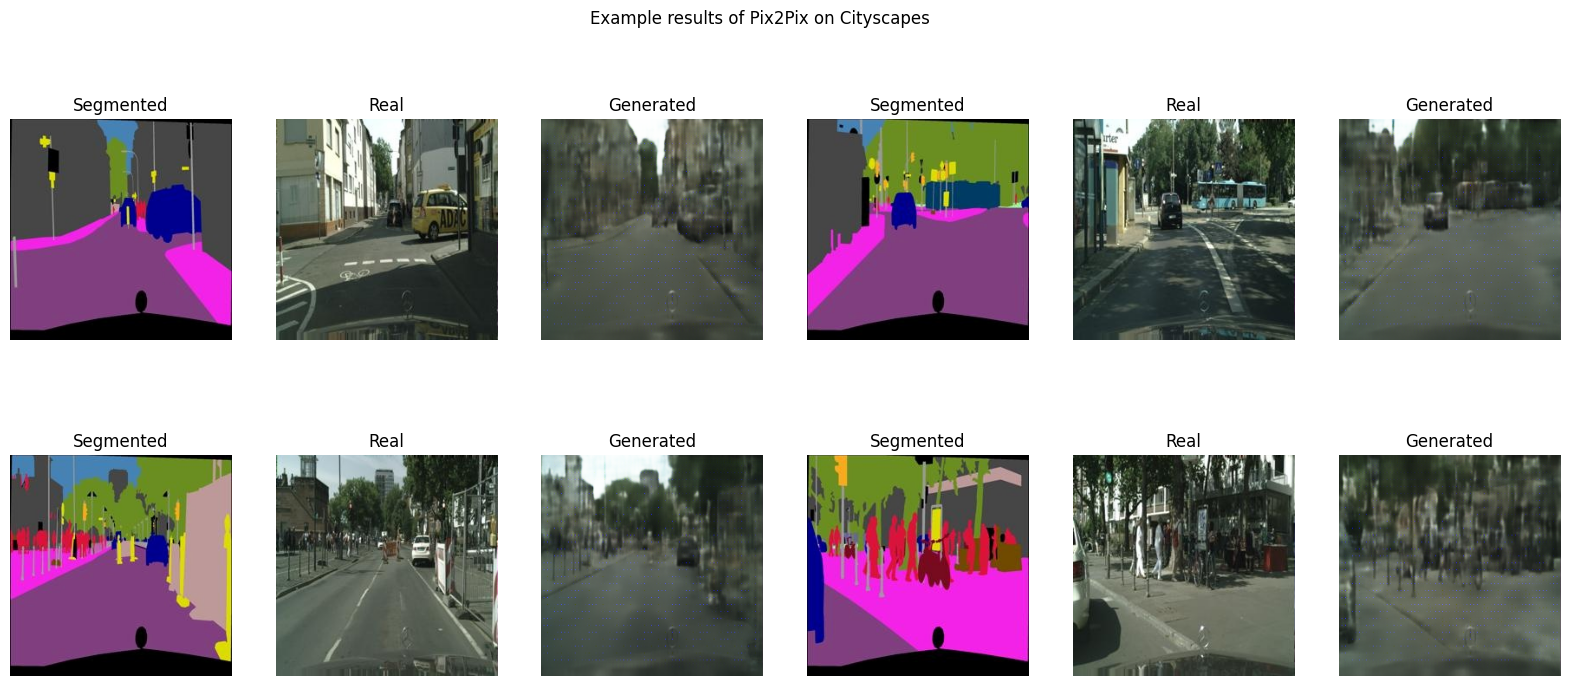

In [15]:
generator.load_state_dict(torch.load('generator.pth', map_location=device, weights_only=True))
visualize(generator, val_loader, device)